In [5]:
import glob, os, sys, toml, pickle, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from os import path

from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool, cpu_count
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor



path_MOASMO = '/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src/'
sys.path.append(path_MOASMO)
import gp
import NSGA2


import os, sys, subprocess, time, toml

sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/")
sys.path.append("/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/allbasin_emulator")
from MOASMO_parameter_allbasin_emulator import *
from multiprocessing import Pool


sys.path.append("/glade/u/home/guoqiang/CTSM_repos/ctsm_optz/MO-ASMO/src")
# import NSGA2


from MOASMO_parameters import *

import torch
import torch.nn as nn
import torch.optim as optim


import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
infile_basin_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
infile_param_info = '/glade/u/home/mozhgana/mywork/model_calibration/src/moasmo_test/param_file_tpl.csv'
infile_attr_foruse = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/camels_attributes_table_TrainModel.csv'
inpath_moasmo = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib'

CV=1
ncpus = 1
iterend = 1
outpathname = 'LSE_spaceCV_PredictParam_4X_ann'
suffix = f'LSEspaceCV_ann_{CV}'
objfunc = 'normKGE'
numruns = 100


In [7]:
CV=1
outpath = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam'
# divide into train/test index
outfile = f'{outpath}/train_test_CV_indices.npz'
if os.path.isfile(outfile):
    dtmp = np.load(outfile, allow_pickle=True)
    train_indices, test_indices = dtmp['train_indices'], dtmp['test_indices']

train_index= train_indices[CV-1]
test_index= test_indices[CV-1]

In [8]:
suffix_defa_source = 'LSEnormKGE'

outpath = f"{inpath_moasmo}/{outpathname}"
os.makedirs(outpath, exist_ok=True)

# Load data: same for all iterations
df_basin_info = pd.read_csv(infile_basin_info)
df_basin_info.index = np.arange(len(df_basin_info))
all_index = np.arange(len(df_basin_info))

test_index = np.setdiff1d(all_index, train_index)

# information for all basins
df_param_info = pd.read_csv(infile_param_info)

file_defa_param = f'{outpath}/camels_summa_defa_param_train_{suffix}.csv'
df_param_defa_train = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, train_index)

file_defa_param = f'{outpath}/camels_summa_defa_param_test_{suffix}.csv'
df_param_defa_test = read_allbasin_defa_params(infile_param_info, file_defa_param, Basin_list, test_index)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_train_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_train_{suffix}.gz'

df_param_lb_train, df_param_ub_train = load_basin_param_bounds(inpath_moasmo, df_param_defa_train, file_param_lb, file_param_ub)

file_param_lb = f'{outpath}/camels_summa_all_param_lb_test_{suffix}.gz'
file_param_ub = f'{outpath}/camels_summa_all_param_ub_test_{suffix}.gz'
df_param_lb_test, df_param_ub_test = load_basin_param_bounds(inpath_moasmo, df_param_defa_test, file_param_lb, file_param_ub)


file_camels_attribute = f'{outpath}/camels_basin_attribute_train_{suffix}.pkl'
df_att_train = read_camels_attributes(infile_basin_info, file_camels_attribute, train_index)
file_camels_attribute = f'{outpath}/camels_basin_attribute_test_{suffix}.pkl'
df_att_test = read_camels_attributes(infile_basin_info, file_camels_attribute, test_index)

df_att_foruse = pd.read_csv(infile_attr_foruse)
useattrs = list(df_att_foruse[df_att_foruse['att_Xie2021'].values]['Attribute_text'].values)
print("The number of attributes used:", len(useattrs))
print(useattrs)


suffixtest = suffix+'test'

# Load data: outputs from each iteration from training basins
for iter in range(0, iterend):
    file_all_param = f'{outpath}/camels_summa_all_param_train_{suffix}_iter{iter}.gz'
    file_all_metric = f'{outpath}/camels_summa_all_metric_train_{suffix}_iter{iter}.gz'
    file_all_basinid = f'{outpath}/camels_summa_all_basinid_train_{suffix}_iter{iter}.gz'

    file_all_param_test = f'{outpath}/camels_summa_all_param_test_{suffix}_iter{iter}.gz'
    file_all_metric_test = f'{outpath}/camels_summa_all_metric_test_{suffix}_iter{iter}.gz'
    file_all_basinid_test = f'{outpath}/camels_summa_all_basinid_test_{suffix}_iter{iter}.gz'

    if iter == 0:

        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix_defa_source)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffix_defa_source)
    else:
        df_param_i, df_metric_i, df_basinid_i = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_train,
                                                                              df_basin_info, iter, file_all_param,
                                                                              file_all_metric, file_all_basinid,
                                                                              train_index, suffix)
    
        df_param_i_test, df_metric_i_test, df_basinid_i_test = load_all_basin_params_metrics(inpath_moasmo, infile_param_info, df_param_defa_test,
                                                                              df_basin_info, iter, file_all_param_test,
                                                                              file_all_metric_test, file_all_basinid_test,
                                                                              test_index, suffixtest)

    df_basinid_i['iter'] = iter
    df_basinid_i_test['iter'] = iter

    if iter == 0:
        df_param = df_param_i
        df_metric = df_metric_i
        df_basinid = df_basinid_i
        
        df_param_test = df_param_i_test
        df_metric_test = df_metric_i_test
        df_basinid_test = df_basinid_i_test
    else:
        df_param = pd.concat([df_param, df_param_i])
        df_metric = pd.concat([df_metric, df_metric_i])
        df_basinid = pd.concat([df_basinid, df_basinid_i])
        
        df_param_test = pd.concat([df_param_test, df_param_i_test])
        df_metric_test = pd.concat([df_metric_test, df_metric_i_test])        
        df_basinid_test = pd.concat([df_basinid_test, df_basinid_i_test])

df_param = df_param.apply(pd.to_numeric, errors='coerce')
df_param_test = df_param_test.apply(pd.to_numeric, errors='coerce')


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


index = np.isnan(np.sum(df_metric.values, axis=1) + np.sum(df_param.values, axis=1))
df_param = df_param[~index]
df_metric = df_metric[~index]
df_basinid = df_basinid[~index]

index_test = np.isnan(np.sum(df_metric_test.values, axis=1) + np.sum(df_param_test.values, axis=1))
df_param_test = df_param_test[~index_test]
df_metric_test = df_metric_test[~index_test]
df_basinid_test = df_basinid_test[~index_test]


df_param.index = np.arange(len(df_param))
df_metric.index = np.arange(len(df_metric))
df_basinid.index = np.arange(len(df_basinid))

df_param_test.index = np.arange(len(df_param_test))
df_metric_test.index = np.arange(len(df_metric_test))
df_basinid_test.index = np.arange(len(df_basinid_test))


print('Number of nan samples:', np.sum(index))
print("Number of original parameter sets:", len(index))
print("Number of final parameter sets:", len(df_param))


# One-hot encoding for categorical attributes
df_att = pd.concat([df_att_train, df_att_test])
df_att.index = np.arange(len(df_att))
df_att_use = df_att[useattrs + ["hru_id"]]

for att in useattrs:
    if df_att_use[att].dtype == "object":
        print('Convert', att, 'to one-hot encoding')
        enc = OneHotEncoder(sparse_output=False)
        enc.fit(df_att_use[[att]])
        encnames = [att + "_" + str(i) for i in range(len(enc.categories_[0]))]
        print('New columns:', encnames)
        df_enc = pd.DataFrame(enc.transform(df_att_use[[att]]), columns=encnames)
        df_att_use = pd.concat([df_att_use, df_enc], axis=1)
        df_att_use = df_att_use.drop([att], axis=1)

df_att_use_train = df_att_use[:len(df_att_train)]
df_att_use_test = df_att_use[len(df_att_train):]
df_att_use_train.index = np.arange(len(df_att_use_train))
df_att_use_test.index = np.arange(len(df_att_use_test))

useattrs = list(df_att_use_train.columns)
useattrs.remove('hru_id')

useattrs_test = list(df_att_use_test.columns)
useattrs_test.remove('hru_id')

# Prepare model input and output
df_input = df_param.copy()
df_input["hru_id"] = df_basinid["basin_name"]
df_input = df_input.merge(df_att_use_train[useattrs + ["hru_id"]], on="hru_id", how="left")
df_input = df_input.drop(["hru_id"], axis=1)

inputnames = list(df_param.columns) + useattrs
x_all = df_input[inputnames].values.copy()
print("Input shape:", x_all.shape)


# divide samples into training and validation sets (70% vs 30%)
hru_idu = np.unique(df_basinid["basin_name"].values)
index_val_tmp = np.linspace(0, len(hru_idu)-1, int(len(hru_idu) * 0.3 )).astype(int)
index_train_tmp = np.setdiff1d(np.arange(len(hru_idu)), index_val_tmp)
hru_idu_train = hru_idu[index_train_tmp]
hru_idu_val = hru_idu[index_val_tmp]

index_train = df_basinid["basin_name"].isin(hru_idu_train)
index_val = df_basinid["basin_name"].isin(hru_idu_val)

x_train, x_val = x_all[index_train, :], x_all[index_val, :]

# Normalize the features
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - x_train_mean) / x_train_std
x_val_scaled = (x_val - x_train_mean) / x_train_std

df_output = df_metric.copy()
y_all = df_output[["kge"]].values.copy()
y_all = y_all / (2 - y_all)  # Normalize KGE
y_train, y_val = y_all[index_train], y_all[index_val]



# Test data
df_input_test = df_param_test .copy()
df_input_test ["hru_id"] = df_basinid_test ["basin_name"]
df_input_test  = df_input_test .merge(df_att_use_test[useattrs_test  + ["hru_id"]], on="hru_id", how="left")
df_input_test  = df_input_test .drop(["hru_id"], axis=1)

inputnames_test  = list(df_param_test .columns) + useattrs_test 
x_all_test  = df_input_test [inputnames_test ].values.copy()
print("Input shape:", x_all_test .shape)

# Normalize the features
x_test_scaled = (x_all_test - x_train_mean) / x_train_std

df_output_test = df_metric_test.copy()
y_all_test = df_output_test[["kge"]].values.copy()
y_all_test = y_all_test / (2 - y_all_test)  # Normalize KGE



File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_train_LSEspaceCV_ann_1.pkl
File exists: /glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/camels_basin_attribute_test_LSEspaceCV_ann_1.pkl
The number of attributes used: 27
['mean_elev', 'mean_slope', 'area_gauges2', 'p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'frac_snow', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq', 'low_prec_dur', 'frac_forest', 'lai_max', 'lai_diff', 'dom_land_cover', 'dom_land_cover_frac', 'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity', 'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 'carbonate_rocks_frac', 'geol_permeability']
Number of nan samples: 406
Number of original parameter sets: 200400
Number of final parameter sets: 199994
Convert dom_land_cover to one-hot encoding
New columns: ['dom_land_cover_0', 'dom_land_cover_1', 'dom_la

In [10]:
        # Train a random forest emulator
        outfile = f'/glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator'
        em_model = train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, model_file=outfile)

Epoch 1, Training Loss: 0.16915975511074066, Validation Loss: 0.16556400060653687
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 2, Training Loss: 0.1306702047586441, Validation Loss: 0.13287295401096344
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 3, Training Loss: 0.10457747429609299, Validation Loss: 0.11140556633472443
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 4, Training Loss: 0.08930681645870209, Validation Loss: 0.09886229038238525
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 5, Training Loss: 0.08209658414125443, Validation Loss: 0.09227767586708069
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 6, Training Loss: 0.07957930117845535, Validation Loss: 0.08884091675281525
Model saved to /glade/derecho/scratch/guoqiang/LSEexps/test_Pytorch_ANN_emulator
Epoch 7, Training Loss:


KeyboardInterrupt



In [11]:
x_train_scaled.shape, y_train.shape

((139994, 52), (139994, 1))

In [13]:
np.mean(x_train_scaled), np.mean(y_train)

(np.float64(-6.89042430848366e-14), np.float64(-0.19446969017921084))

In [ ]:
import torch
import torch.nn as nn
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load preprocessed input features (x_train_scaled) and target values (y_train) for training


# Define paths to saved models
ann_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1'
rf_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X/RF_emulator_for_iter1_LSEspaceCV_1.pkl'

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

    # Add a predict method similar to sklearn's
    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        self.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            predictions = self.forward(X)
        return predictions.numpy()  # Convert the predictions back to numpy


# Load ANN emulator
ann_model = SimpleNN(input_size=x_train_scaled.shape[1])
ann_model.load_state_dict(torch.load(ann_path))

# Load RF emulator
rf_model = joblib.load(rf_path)

# Convert input features to tensor for ANN model
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)

# Make predictions with ANN emulator
ann_model.eval()
with torch.no_grad():
    ann_predictions = ann_model(x_train_tensor).numpy().flatten()

# Make predictions with RF emulator
rf_predictions = rf_model.predict(x_all)

# Evaluate accuracy of each model
ann_mse = mean_squared_error(y_train, ann_predictions)
rf_mse = mean_squared_error(y_all, rf_predictions)
ann_r2 = r2_score(y_train, ann_predictions)
rf_r2 = r2_score(y_all, rf_predictions)

print("ANN Emulator - MSE:", ann_mse, "R^2:", ann_r2)
print("RF Emulator - MSE:", rf_mse, "R^2:", rf_r2)


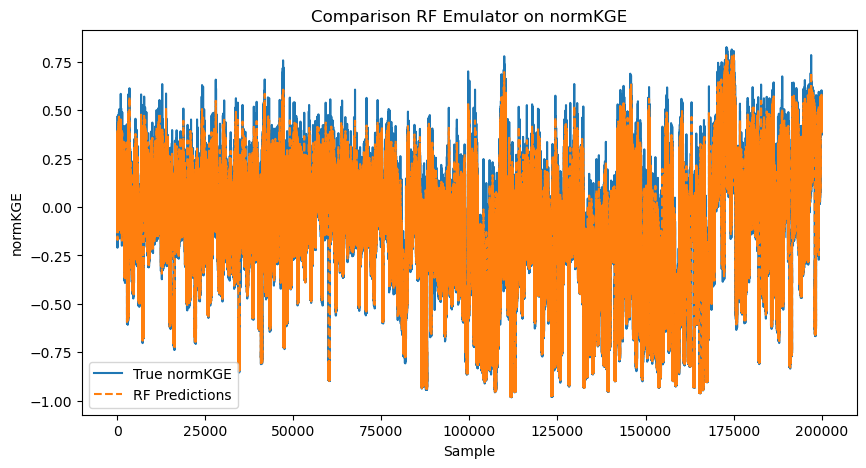

In [6]:
# Visual comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_all, label='True normKGE')
plt.plot(rf_predictions, label='RF Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison RF Emulator on normKGE")
plt.show()


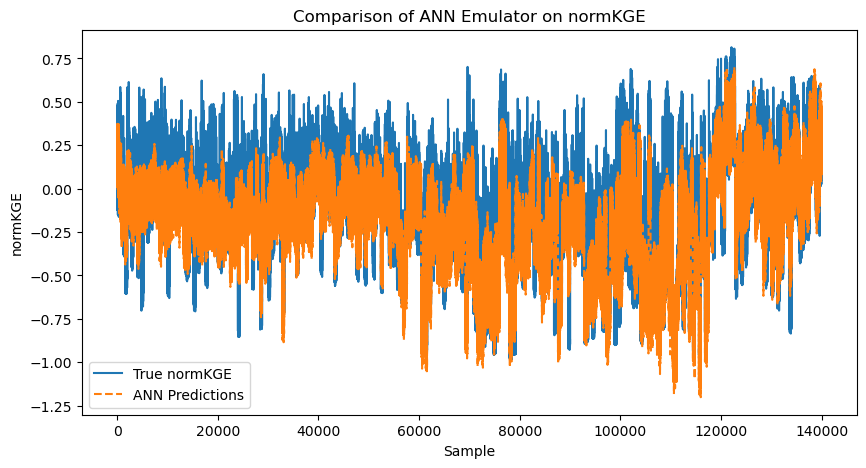

In [7]:
# Visual comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train, label='True normKGE')
plt.plot(ann_predictions, label='ANN Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison of ANN Emulator on normKGE")
plt.show()

ANN Emulator - Test MSE: 0.04466610292825665 Test R²: 0.5968479101662916
RF Emulator - Test MSE: 0.04090204786768992 Test R²: 0.6308219209805781


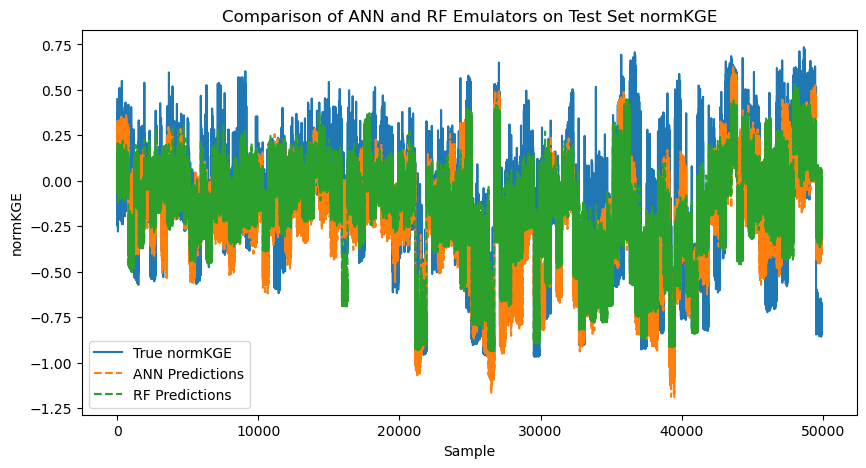

In [8]:
import torch
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define paths to saved models
ann_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X_ann/ANN_emulator_for_iter1_LSEspaceCV_ann_1'
rf_path = '/glade/campaign/cgd/tss/people/mozhgana/projects/SUMMA_Calib/LSE_spaceCV_PredictParam_4X/RF_emulator_for_iter1_LSEspaceCV_1.pkl'


# Define the ANN model class (ensure it matches the trained model's architecture)
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32)

        self.eval()
        with torch.no_grad():
            predictions = self.forward(X)
        return predictions.numpy()

# Load the ANN model
ann_model = SimpleNN(input_size=x_test_scaled.shape[1])
ann_model.load_state_dict(torch.load(ann_path))

# Load the RF model
rf_model = joblib.load(rf_path)

# Convert test input to tensor for ANN model predictions
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

# Generate predictions using the ANN model
ann_model.eval()
with torch.no_grad():
    ann_test_predictions = ann_model(x_test_tensor).numpy().flatten()

# Generate predictions using the RF model
rf_test_predictions = rf_model.predict(x_all_test)

# Evaluate accuracy of each model on the test set
ann_test_mse = mean_squared_error(y_all_test, ann_test_predictions)
rf_test_mse = mean_squared_error(y_all_test, rf_test_predictions)
ann_test_r2 = r2_score(y_all_test, ann_test_predictions)
rf_test_r2 = r2_score(y_all_test, rf_test_predictions)

# Print comparison metrics
print("ANN Emulator - Test MSE:", ann_test_mse, "Test R²:", ann_test_r2)
print("RF Emulator - Test MSE:", rf_test_mse, "Test R²:", rf_test_r2)

# Plot comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_all_test, label='True normKGE')
plt.plot(ann_test_predictions, label='ANN Predictions', linestyle='--')
plt.plot(rf_test_predictions, label='RF Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison of ANN and RF Emulators on Test Set normKGE")
plt.show()


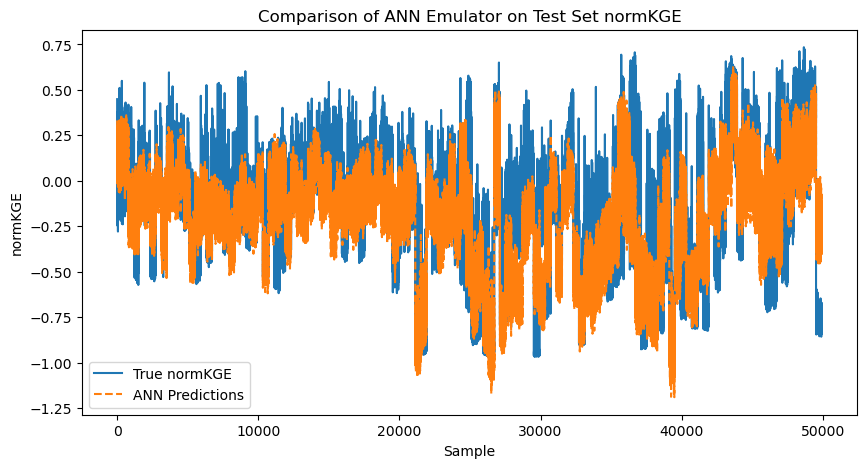

In [9]:
# Plot comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_all_test, label='True normKGE')
plt.plot(ann_test_predictions, label='ANN Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison of ANN Emulator on Test Set normKGE")
plt.show()


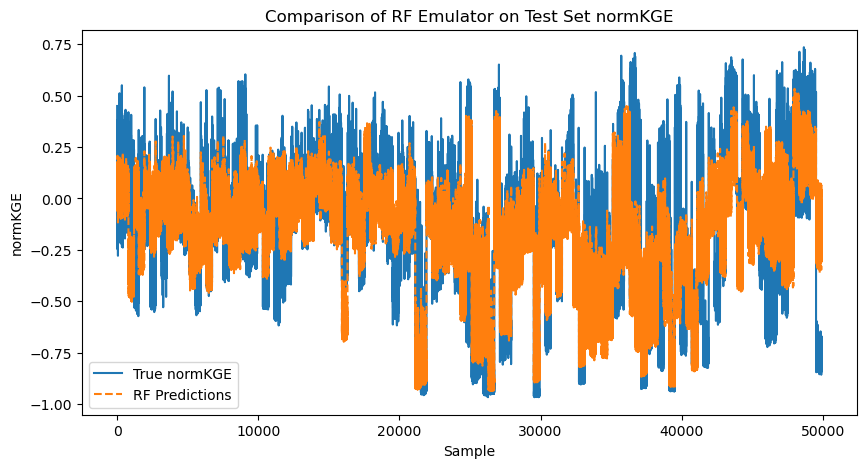

In [10]:
# Plot comparison of predictions
plt.figure(figsize=(10, 5))
plt.plot(y_all_test, label='True normKGE')
plt.plot(rf_test_predictions, label='RF Predictions', linestyle='--')
plt.xlabel("Sample")
plt.ylabel("normKGE")
plt.legend()
plt.title("Comparison of RF Emulator on Test Set normKGE")
plt.show()


In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 200)
        self.fc2 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


class DeepNN(nn.Module):
    def __init__(self, input_size):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class WideNN(nn.Module):
    def __init__(self, input_size):
        super(WideNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)  # Add batch normalization
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)


In [12]:
def train_and_evaluate_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, n_epochs=1000, patience=10, lr=0.001):
    model = model_class(input_size=input_size)  # Initialize the model with the input size
    
    # Specify a unique file name for each model class
    model_file = f"{model_class.__name__}_model.pth"
    
    # Train the model and save to its unique file
    model = train_nn_model_pytorch(x_train_scaled, y_train, x_val_scaled, y_val, n_epochs, patience, lr, model_file=model_file)

    # Evaluate model performance on the training and validation data
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    with torch.no_grad():
        ann_predictions = model.predict(x_train_tensor)

    ann_mse = mean_squared_error(y_train, ann_predictions.flatten())
    ann_r2 = r2_score(y_train, ann_predictions.flatten())

    print(f"{model_class.__name__} - Train MSE: {ann_mse:.4f}, R²: {ann_r2:.4f}")
    return model



In [19]:
# Define input size from your data
input_size = x_train_scaled.shape[1]

# Test SimpleNN
print("Testing SimpleNN")
simple_nn_model = train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)

# SimpleNN - Train MSE: 0.0237, R²: 0.7727

# Test DeepNN
print("\nTesting DeepNN")
deep_nn_model = train_and_evaluate_model(DeepNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)

# DeepNN - Train MSE: 0.0241, R²: 0.7687

# Test WideNN
print("\nTesting WideNN")
wide_nn_model = train_and_evaluate_model(WideNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)
# WideNN - Train MSE: 0.0236, R²: 0.7740

In [21]:
import torch
import torch.nn as nn
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Define adjusted models
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_units=200):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class DeepNN(nn.Module):
    def __init__(self, input_size, dropout_prob=0.2):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)





# Training function with added flexibility for parameters
def train_and_evaluate_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                             hidden_units=200, dropout_prob=0.2, lr=0.001, n_epochs=1000, patience=20):
    
    model_file = f"{model_class.__name__}_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units) if model_class == SimpleNN \
            else model_class(input_size=input_size, dropout_prob=dropout_prob)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
            print(f"Model saved to {model_file}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        ann_predictions = model(x_train_tensor).numpy().flatten()
    ann_mse = mean_squared_error(y_train, ann_predictions)
    ann_r2 = r2_score(y_train, ann_predictions)

    print(f"{model_class.__name__} - Train MSE: {ann_mse:.4f}, R²: {ann_r2:.4f}")
    return model

# Try different configurations
input_size = x_train_scaled.shape[1]

# 1. SimpleNN with different learning rates
print("\nTesting SimpleNN with learning rate 0.0005")
train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, lr=0.0005)

# SimpleNN - Train MSE: 0.0232, R²: 0.7778

print("\nTesting SimpleNN with learning rate 0.0001")
train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, lr=0.0001)

# SimpleNN - Train MSE: 0.0256, R²: 0.7547

# 2. SimpleNN with more hidden units
print("\nTesting SimpleNN with 300 hidden units")
train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, hidden_units=300)

# SimpleNN - Train MSE: 0.0250, R²: 0.7601

print("\nTesting SimpleNN with 400 hidden units")
train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, hidden_units=400)
# SimpleNN - Train MSE: 0.0258, R²: 0.7528


# 3. DeepNN with reduced dropout probability
print("\nTesting DeepNN with dropout probability 0.1")
train_and_evaluate_model(DeepNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, dropout_prob=0.1)

# DeepNN - Train MSE: 0.0222, R²: 0.7868

print("\nTesting DeepNN with dropout probability 0.05")
train_and_evaluate_model(DeepNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, dropout_prob=0.05)

# DeepNN - Train MSE: 0.0227, R²: 0.7828


In [22]:
import torch
import torch.nn as nn
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_units=200, use_batch_norm=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.bn1 = nn.BatchNorm1d(hidden_units) if use_batch_norm else None
        self.fc2 = nn.Linear(hidden_units, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        if self.bn1:
            x = self.bn1(x)
        return self.fc2(x)

class DeepNN(nn.Module):
    def __init__(self, input_size, dropout_prob=0.2):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 200)  # Increased units for fc2
        self.fc3 = nn.Linear(200, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_and_evaluate_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                             hidden_units=200, dropout_prob=0.2, use_batch_norm=False, lr=0.001, n_epochs=1000, patience=20):
    
    model_file = f"{model_class.__name__}_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units, use_batch_norm=use_batch_norm) if model_class == SimpleNN \
            else model_class(input_size=input_size, dropout_prob=dropout_prob)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        ann_predictions = model(x_train_tensor).numpy().flatten()
    ann_mse = mean_squared_error(y_train, ann_predictions)
    ann_r2 = r2_score(y_train, ann_predictions)

    print(f"{model_class.__name__} - Train MSE: {ann_mse:.4f}, R²: {ann_r2:.4f}")
    return model

# Try refined configurations
input_size = x_train_scaled.shape[1]

# Testing refined SimpleNN with batch normalization and lower learning rate
print("\nTesting SimpleNN with 0.0003 learning rate, 300 hidden units, and batch normalization")
train_and_evaluate_model(SimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                         hidden_units=300, use_batch_norm=True, lr=0.0003, patience=30)

# Testing DeepNN with 0.01 dropout and increased units in fc2 layer
print("\nTesting DeepNN with 0.01 dropout probability and 200 units in fc2")
train_and_evaluate_model(DeepNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                         dropout_prob=0.01, n_epochs=500, patience=30)




Testing SimpleNN with 0.0003 learning rate, 300 hidden units, and batch normalization
Early stopping triggered.
SimpleNN - Train MSE: 0.0209, R²: 0.8001

Testing DeepNN with 0.01 dropout probability and 200 units in fc2
Early stopping triggered.
DeepNN - Train MSE: 0.0243, R²: 0.7672


DeepNN(
  (fc1): Linear(in_features=52, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
)

In [28]:
class ImprovedOptimizedSimpleNN(nn.Module):
    def __init__(self, input_size, hidden_units=300):
        super(ImprovedOptimizedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.bn1 = nn.BatchNorm1d(hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.bn2 = nn.BatchNorm1d(hidden_units // 2)
        self.fc3 = nn.Linear(hidden_units // 2, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

def train_and_evaluate_improved_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                                      hidden_units=300, lr=0.0001, n_epochs=1000, patience=50):
    
    model_file = f"{model_class.__name__}_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
            # print(f"Model saved to {model_file}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        ann_predictions = model(x_train_tensor).numpy().flatten()
    ann_mse = mean_squared_error(y_train, ann_predictions)
    ann_r2 = r2_score(y_train, ann_predictions)

    print(f"{model_class.__name__} - Train MSE: {ann_mse:.4f}, R²: {ann_r2:.4f}")
    return model

# Test the improved model
input_size = x_train_scaled.shape[1]
print("\nTesting ImprovedOptimizedSimpleNN with batch normalization only on hidden layers")
train_and_evaluate_improved_model(ImprovedOptimizedSimpleNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val, hidden_units=300, lr=0.0001, patience=50)



Testing ImprovedOptimizedSimpleNN with batch normalization only on hidden layers
Early stopping triggered.
ImprovedOptimizedSimpleNN - Train MSE: 0.0194, R²: 0.8141


ImprovedOptimizedSimpleNN(
  (fc1): Linear(in_features=52, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (bn2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=150, out_features=1, bias=True)
)

In [31]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedNN(nn.Module):
    def __init__(self, input_size, hidden_units=[300, 200, 100], use_batch_norm=True, dropout_prob=0.2):
        super(EnhancedNN, self).__init__()
        layers = []
        for i, units in enumerate(hidden_units):
            layers.append(nn.Linear(input_size if i == 0 else hidden_units[i-1], units))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(units))
            layers.append(nn.ReLU())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_units[-1], 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def train_and_evaluate_enhanced_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                                      hidden_units=[300, 200, 100], dropout_prob=0.2, lr=0.0001, n_epochs=2000, patience=100):


    
    model_file = f"{model_class.__name__}_best_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units, dropout_prob=dropout_prob)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)  # Add weight decay for L2 regularization
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
            # print(f"Model saved to {model_file}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        train_predictions = model(x_train_tensor).numpy().flatten()
    train_mse = mean_squared_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    print(f"{model_class.__name__} - Train MSE: {train_mse:.6f}, R²: {train_r2:.6f}")
    return model

# Try the enhanced model
input_size = x_train_scaled.shape[1]
print("\nTesting EnhancedNN with additional layers and dropout")
enhanced_model = train_and_evaluate_enhanced_model(EnhancedNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)


Testing EnhancedNN with additional layers and dropout
Early stopping triggered.
EnhancedNN - Train MSE: 0.022767, R²: 0.781752


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedOptimizedNN(nn.Module):
    def __init__(self, input_size, hidden_units=300):
        super(EnhancedOptimizedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.bn1 = nn.BatchNorm1d(hidden_units)
        self.dropout1 = nn.Dropout(0.1)
        
        self.fc2 = nn.Linear(hidden_units, hidden_units // 2)
        self.bn2 = nn.BatchNorm1d(hidden_units // 2)
        self.dropout2 = nn.Dropout(0.1)
        
        self.fc3 = nn.Linear(hidden_units // 2, hidden_units // 4)
        self.bn3 = nn.BatchNorm1d(hidden_units // 4)
        self.dropout3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(hidden_units // 4, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc4(x)

def train_and_evaluate_enhanced_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                                      hidden_units=300, lr=0.0001, n_epochs=1000, patience=50):
    
    model_file = f"{model_class.__name__}_best_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        print(f'Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
            print(f"Model saved to {model_file}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        train_predictions = model(x_train_tensor).numpy().flatten()
    train_mse = mean_squared_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    print(f"{model_class.__name__} - Train MSE: {train_mse:.6f}, R²: {train_r2:.6f}")
    return model

# Try the enhanced model
input_size = x_train_scaled.shape[1]
print("\nTesting EnhancedOptimizedNN with additional layer, dropout, and learning rate scheduling")
enhanced_model = train_and_evaluate_enhanced_model(EnhancedOptimizedNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)


# EnhancedOptimizedNN - Train MSE: 0.016313, R²: 0.843624



In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

class EnhancedImprovedNN(nn.Module):
    def __init__(self, input_size, hidden_units=[300, 200, 200, 150, 100], dropout_prob=0.3):
        super(EnhancedImprovedNN, self).__init__()
        layers = []
        for i, units in enumerate(hidden_units):
            layers.append(nn.Linear(input_size if i == 0 else hidden_units[i-1], units))
            if i < len(hidden_units) - 1:  # Apply batch norm selectively
                layers.append(nn.BatchNorm1d(units))
            layers.append(nn.LeakyReLU())  # Experimenting with LeakyReLU for more nuanced gradients
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(hidden_units[-1], 1))  # Final layer without activation
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_and_evaluate_enhanced_model(model_class, input_size, x_train_scaled, y_train, x_val_scaled, y_val, 
                                      hidden_units=[300, 200, 200, 150, 100], dropout_prob=0.3, lr=0.00001, 
                                      weight_decay=1e-4, n_epochs=2000, patience=150):
    
    model_file = f"{model_class.__name__}_best_model.pth"
    model = model_class(input_size=input_size, hidden_units=hidden_units, dropout_prob=dropout_prob)
    
    x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    criterion = nn.SmoothL1Loss()  # Use SmoothL1Loss for more robustness against outliers
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(x_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_predictions = model(x_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
            torch.save(model.state_dict(), model_file)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

    model.load_state_dict(torch.load(model_file))

    with torch.no_grad():
        train_predictions = model(x_train_tensor).numpy().flatten()
    train_mse = mean_squared_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    print(f"{model_class.__name__} - Train MSE: {train_mse:.6f}, R²: {train_r2:.6f}")
    return model

# Testing the enhanced model with fine-tuning
input_size = x_train_scaled.shape[1]
print("\nTesting EnhancedImprovedNN with refined layers, dropout, and alternative activation")
enhanced_model = train_and_evaluate_enhanced_model(EnhancedImprovedNN, input_size, x_train_scaled, y_train, x_val_scaled, y_val)



Testing EnhancedImprovedNN with refined layers, dropout, and alternative activation
EnhancedImprovedNN - Train MSE: 0.029014, R²: 0.721868
